In [1]:
from orphics import cosmology

In [3]:
import numpy as np
from orphics import maps, cosmology,io,stats
from scipy import optimize
import cosmo_cleaner
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
#from IPython.display import set_matplotlib_formats set_matplotlib_formats('retina')
csfont = {'fontname':'Latin Modern Roman'}
font = font_manager.FontProperties(family='Latin Modern Roman',style='normal', size = 8)

In [600]:
from cosmo_cleaner import fisher


In [750]:
lc=cosmology.LimberCosmology(lmax=2000,pickling=True)

Generating theory Cls...
initializing power...
Initializing CMB window..


In [751]:
defaultCosmology = {'omch2': 0.1198
                    ,'ombh2': 0.02225
                    ,'H0': 67.3
                    ,'ns': 0.9645
                    ,'As': 2.2e-9
                    ,'mnu': 0.06
                    ,'w0': -1.0
                    ,'tau':0.06
                    ,'nnu':3.046
                    ,'wa': 0.
}

In [752]:
import camb
pars = camb.CAMBparams()
pars.set_dark_energy(w=defaultCosmology['w0'],wa = defaultCosmology['wa'], dark_energy_model = 'ppf')
pars.set_cosmology(H0=defaultCosmology['H0'], cosmomc_theta = None,ombh2=defaultCosmology['ombh2'], 
               omch2=defaultCosmology['omch2'], mnu=defaultCosmology['mnu'], tau = defaultCosmology['tau'],
               nnu = defaultCosmology['nnu'], num_massive_neutrinos = 3)
#pars.NonLinear = model.NonLinear_both
pars.InitPower.set_params(ns=defaultCosmology['ns'],As=defaultCosmology['As'])

results = camb.get_results(pars)

    

In [753]:
nz = 1000
kmax = 10
zmin = 0.
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)

dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]
Hzs = np.array([results.hubble_parameter(z) for z in zs])
pars.Transfer.accurate_massive_neutrinos = True    

PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
hubble_units=False, k_hunit=False, kmax=kmax,
var1='delta_nonu',var2='delta_nonu', zmax=zs[-1])

In [754]:
ells=np.arange(2000)

cSpeedKmPerSec = 299792.458
omnuh2 = pars.omnuh2

#lensing window
lensingwindow = 1.5*(defaultCosmology['omch2']+defaultCosmology['ombh2']+omnuh2)*100.*100.*(1.+zs)*chis*((chistar - chis)/chistar)/Hzs/cSpeedKmPerSec

#Phi_window
L=np.arange(len(lensingwindow))
lensingphi=lensingwindow*2/L**2



/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [755]:
w = np.ones(chis.shape)
wg = np.ones(chis.shape)
wk = np.ones(chis.shape)

precalcFactor= Hzs**2./chis/chis/cSpeedKmPerSec**2.


In [756]:
clkk = []

for l in ells:
    k=(l+0.5)/chis
    wk[:]=1
    wk[k<1e-4]=0
    wk[k>=kmax]=0
    pkin = PK.P(zs, k, grid=False)
    common = ((wk*pkin)*precalcFactor)[zs>=zmin]        
    estCl = np.dot(dchis[zs>=zmin], common*(lensingwindow*lensingwindow)[zs>=zmin])
    clkk.append(estCl)

In [757]:
cltheory=np.loadtxt("/global/homes/j/jia_qu/so-lenspipe/data/clkk.txt")[:1000]

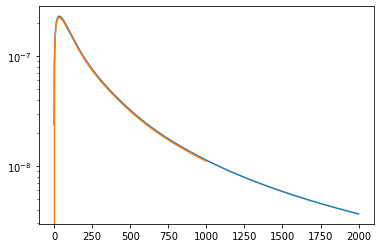

In [758]:
plt.semilogy(clkk)
plt.semilogy(cltheory)

### cib cross kappa

In [899]:
def cib_window(nu,b=3.6e-62):
    z_c=2
    sigma_z=2
    beta=2
    nu=nu*10**9
    T=34
    k=1.38064852e-23
    h=6.62607015e-34
    f_nu=lambda x: ((np.exp(h*x/(k*T))-1)**(-1))*x**(beta+3)
    eta_0=1.5e18
    return b*(chis**2/(1.+zs)**2)*np.exp(-(zs-z_c)**2/(2*sigma_z**2))*f_nu(nu*(1+zs))

In [897]:
cib_window(545,b=3.6e-62)

/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [875]:
cl_cibk=[]
wkc = np.ones(chis.shape)

ells=np.arange(2000)
for l in ells:
    k=(l)/chis
    wkc[:]=1
    wkc[k<1e-4]=0
    wkc[k>=kmax]=0
    pkin = PK.P(zs, k, grid=False)
    common = ((wkc*pkin)*precalcFactor)[zs>=zmin]        
    estCl = np.dot(dchis[zs>=zmin], common*(lensingwindow*cib_window)[zs>=zmin])
    cl_cibk.append(estCl)
    


/global/homes/j/jia_qu/.local/lib/python3.7/site-packages/camb/results.py:953: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


In [876]:
import pandas as pd
planck=pd.read_csv("/global/homes/j/jia_qu/cosmo_cleaner/notebooks/planck.csv")

In [877]:
L=np.arange(len(np.array(cl_cibk)))
factor=2*L**3/L**2 #convert from kappa to phi with multiplicative factor in front

/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


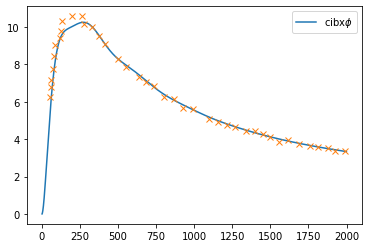

In [878]:
plt.plot(np.array(cl_cibk)*factor,label='cibx$\phi$')
plt.plot(planck['ells'],planck['power'],'x')
plt.legend()

## WINDOW FUNCTION FOR GALAXY

In [824]:
def dndz_gauss(bias,z,z0,sigma):
    ans = 1/np.sqrt(2*np.pi*sigma**2)* np.exp((-(z-z0)**2)/ (2.*sigma**2.))
    return bias*ans 

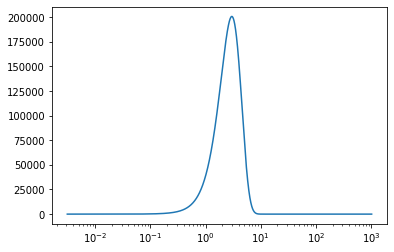

In [825]:
plt.semilogx(zs,cib_window)


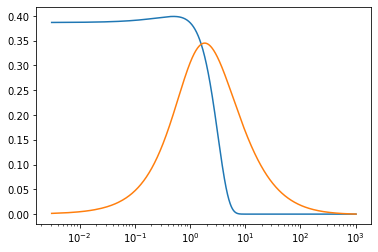

In [945]:
plt.plot(zs,galaxywindow)

plt.semilogx(zs,lensingwindow)
#plt.semilogx(zs,cib_window)


In [900]:
def get_clgg(bias,zs,mean_z,width,lmax=2000):
    galaxywindow=dndz_gauss(bias,zs,mean_z,width)
    cl_autog=[]
    ellsgg=np.arange(lmax)
    for l in ellsgg:
        k=(l+0.5)/chis
        wg[:]=1
        wg[k<1e-4]=0
        wg[k>=kmax]=0
        pkin = PK.P(zs, k, grid=False)
        common = ((wg*pkin)*precalcFactor)[zs>=zmin]        
        estCl = np.dot(dchis[zs>=zmin], common*(galaxywindow*galaxywindow)[zs>=zmin])
        cl_autog.append(estCl)
    return np.array(cl_autog)

def get_clcibk(lensingwindow,cib_window,lmax=2000):
    cl_cibk=[]
    wkc = np.ones(chis.shape)

    ells=np.arange(2000)
    for l in ells:
        k=(l)/chis
        wkc[:]=1
        wkc[k<1e-4]=0
        wkc[k>=kmax]=0
        pkin = PK.P(zs, k, grid=False)
        common = ((wkc*pkin)*precalcFactor)[zs>=zmin]        
        estCl = np.dot(dchis[zs>=zmin], common*(lensingwindow*cib_window)[zs>=zmin])
        cl_cibk.append(estCl)
    return np.array(cl_cibk)

def get_clkg(bias,zs,mean_z,width,lensingwindow,lmax=2000):
    ellsgg=np.arange(lmax)
    cl_cross=[]
    for l in ellsgg:
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        pkin = PK.P(zs, k, grid=False)
        common = ((w*pkin)*precalcFactor)[zs>=zmin]        
        estCl = np.dot(dchis[zs>=zmin], common*(lensingwindow*galaxywindow)[zs>=zmin])
        cl_cross.append(estCl)
    return np.array(cl_cross)

def get_clcib(cib_window,lmax=2000):
    cl_cib=[]
    ells=np.arange(lmax)
    for l in ells:
        k=(l)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        pkin = PK.P(zs, k, grid=False)
        common = ((w*pkin)*precalcFactor)[zs>=zmin]        
        estCl = np.dot(dchis[zs>=zmin], common*(cib_window*cib_window)[zs>=zmin])
        cl_cib.append(estCl) 
    return np.array(cl_cib)

def get_clcibg(bias,zs,mean_z,width,cib_window,lmax=2000):
    galaxywindow=dndz_gauss(bias,zs,mean_z,width)
    cl_cibg=[]
    ells=np.arange(2000)
    wcg = np.ones(chis.shape)

    for l in ells:
        k=(l)/chis
        wcg[:]=1
        wcg[k<1e-4]=0
        wcg[k>=kmax]=0
        pkin = PK.P(zs, k, grid=False)
        common = ((w*pkin)*precalcFactor)[zs>=zmin]        
        estCl = np.dot(dchis[zs>=zmin], common*(cib_window*galaxywindow)[zs>=zmin])
        cl_cibg.append(estCl) 
    return np.array(cl_cibg)

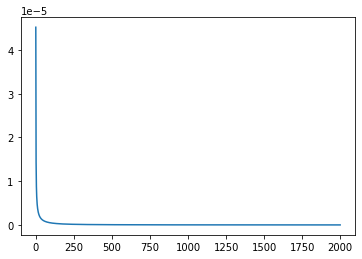

In [881]:
plt.plot(get_clgg(2,zs,0.5,2,lmax=2000))

In [893]:
bias=2
mean_z=0.5
width=2

In [969]:
bias=2
mean_z=0.5
width=2
clgg=get_clgg(bias,zs,mean_z,width,lmax=2000)
clkg=get_clkg(bias,zs,mean_z,width,lensingwindow,lmax=2000)
clcibcib=get_clcib(cib_window(545,b=3.6e-62),lmax=2000)
clcibk=get_clcibk(lensingwindow,cib_window(545,b=3.6e-62),lmax=2000)
clcibg=get_clcibg(bias,zs,mean_z,width,cib_window(545,b=3.6e-62),lmax=2000)
clkk=np.array(clkk)
clgg0=clgg/4
clgk0=clkg/2


/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/global/homes/j/jia_qu/.local/lib/python3.7/site-packages/camb/results.py:953: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


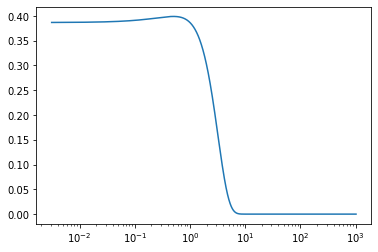

In [970]:
plt.semilogx(zs,galaxywindow)


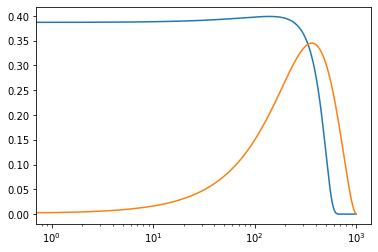

In [971]:
#plot window function
galaxywindow=dndz_gauss(bias,zs,mean_z,width)
#plt.semilogx(cib_window(545,b=3.6e-62),label="cib window")
plt.semilogx(galaxywindow,label='cmb galaxy window')
plt.semilogx(lensingwindow,label='cmb lensing window')


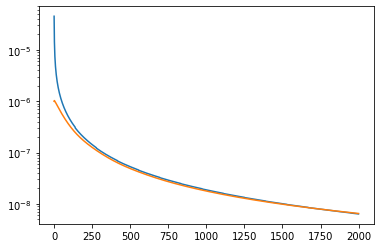

In [972]:
plt.plot(clgg)
plt.semilogy(2*clkg)

In [973]:
cibcl0545=np.loadtxt("/global/homes/j/jia_qu/redshift_cleaning/cibcl0545.txt")[:2000]
from szar import foregrounds
ellrange=np.arange(2000)
nu0 = 545
clcibcib145 = foregrounds.power_cibc(ellrange, nu1 = nu0)+foregrounds.power_cibp(ellrange, nu1 = nu0)

/global/u1/j/jia_qu/szar/szar/foregrounds.py:101: RuntimeWarning: divide by zero encountered in true_divide
  ans = A_cibc * (ells/ell0sec) ** (2.-n_cib)  *2.*np.pi*np.nan_to_num(1./ells/(ells+1.))
/global/u1/j/jia_qu/szar/szar/foregrounds.py:94: RuntimeWarning: divide by zero encountered in true_divide
  ans = A_cibp * (ells/ell0sec) ** 2.0  *2.*np.pi*np.nan_to_num(1./ells/(ells+1.))


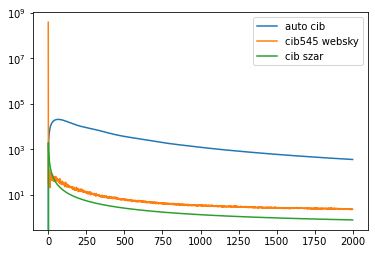

In [974]:
plt.semilogy(clcibcib,label='auto cib')
plt.semilogy(cibcl0545,label='cib545 websky')
plt.semilogy(clcibcib145,label='cib szar')
plt.legend()

Multiplying clkg by the bias results in the clgg as expected.

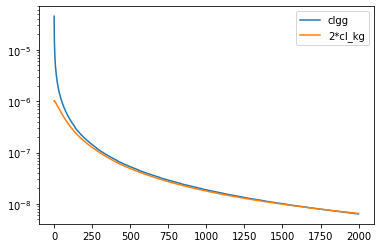

In [925]:
plt.semilogy(clgg,label='clgg')
plt.semilogy(2*clkg,label='2*cl_kg')
plt.legend()

Lets examine the correlation coefficients

/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


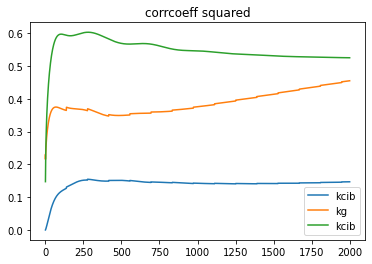

In [975]:
rhocibg_2 = clcibg**2/(clcibcib*clgg)
rhokg_2 = clkg**2/(clkk*clgg) 
rhokcib_2 = clcibk**2/(clcibcib*clkk) 
plt.plot(rhocibg_2,label="kcib")
plt.plot(rhokg_2,label="kg")
plt.plot(rhokcib_2,label="kcib")
plt.title("corrcoeff squared")
plt.legend()

In [976]:
bias=2
mean_z=0.2
width=1
clgg=get_clgg(bias,zs,mean_z,width,lmax=2000)
clkg=get_clkg(bias,zs,mean_z,width,lensingwindow,lmax=2000)
clcibcib=get_clcib(cib_window(545,b=3.6e-62),lmax=2000)
#clcibcib=cibcl0545[:2000]
#clcibcib=clcibcib145[:2000]

clcibk=get_clcibk(lensingwindow,cib_window(545,b=3.6e-62),lmax=2000)
clcibg=get_clcibg(bias,zs,mean_z,width,cib_window(545,b=3.6e-62),lmax=2000)
clkk=np.array(clkk)
clgg0=clgg/4
clgk0=clkg/2


/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/global/homes/j/jia_qu/.local/lib/python3.7/site-packages/camb/results.py:953: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


In [977]:
compare_cleaning(clgg,clcibcib,clkk,clkg,clcibk,clcibg,cut=400,fsky=1)

[[84798.60460257]]
[[84798.60460257]]
Base error is [[0.00343404]]
[[94935.26955611]]
[[94935.26955611]]
5.489391580488617 % improvement with cleaning


/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:69: RuntimeWarning: divide by zero encountered in true_divide
  result = 1/self.Nmodes*(self.get_spectra_element(X, W)*self.get_spectra_element(Y, Z)+self.get_spectra_element(X, Z)*self.get_spectra_element(Y, W))
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:101: RuntimeWarning: divide by zero encountered in power
  self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)
/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


(0.0034340423526889384, 0.0032455343209100186)

In [697]:
def compare_cleaning(clgg,clcibcib,clkk,clkg,clcibk,clcibg,cut=500,fsky=1):
    clgg0=clgg/4
    clgk0=clkg/2
    ellrange=np.arange(cut)
    
    #calculate the base error
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': clkk[:cut]}
    spectra_used = ['kg', 'gg']
    pars = ['b']#, 's'
    Npars = len(pars)
    der_spectra_alpha = np.ones((len(clkg[:cut]), num_spectra, Npars))
    #Derivatives with respect to b
    der_spectra_alpha[:, 0, 0] = clgk0[:cut]
    der_spectra_alpha[:, 1, 0] = 2*bias*clgg0[:cut]
    
    F_kg_gg_only = fisher.Forecaster(fsky, ellrange, ['k', 'g'], spectra, use_as_data =spectra_used)

    F_kg_gg_only.prepare_cov_for_error()
    err_kg_gg_only = F_kg_gg_only.make_fisher_and_err_bars(pars, der_spectra_alpha) 
    print(f'Base error is {err_kg_gg_only}')   
    
    #incorporate cib
    ## Now combine convergence and CIB
    spectra_cross = {'k': clkg[:cut], 'i': clcibg[:cut]}
    spectra_auto = {'kk': clkk[:cut], 'ii': clcibcib[:cut], 'ki': clcibk[:cut]}
    C = fisher.Combiner(ellrange, spectra_cross, spectra_auto)
    a = np.ones((len(ellrange), 2)) 
    all_x=-clcibk[:cut]/clcibcib[:cut]
    a = np.ones((len(ellrange), 2)) 
    a[:, 1] = all_x
    cross, auto = C.combine(a = a)
    cross = clkg #do not change clkg, as ideally this should not be affected by cleaning, in this case they are the same
    spectra = {'kg': cross[:cut], 'gg' :clgg[:cut], 'kk': auto[:cut]}
    pars = ['b']#, 's']
    Npars = len(pars)
    der_spectra_alpha = np.ones((len(clkg[:cut]), 3, Npars))
    #Derivatives with respect to b
    der_spectra_alpha[:, 0, 0] = cross[:cut]/bias
    der_spectra_alpha[:, 1, 0] = 2*bias*clgg0[:cut]
    der_spectra_alpha[:, 2, 0] = clkk[:cut]*np.zeros(len(clkk[:cut]))
    F=fisher.Forecaster(fsky,ellrange,['k','g'],spectra)
    F.prepare_cov_for_error()
    result=F.make_fisher_and_err_bars(pars,der_spectra_alpha)
    print(f'{100*(err_kg_gg_only[0][0]-result[0][0])/err_kg_gg_only[0][0]} % improvement with cleaning')
    return (err_kg_gg_only[0][0],result[0][0])